# Neural Networks vs KNN vs XGBoost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.feather as feather
import torch
from tqdm.notebook import tqdm
tqdm.pandas()
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

First, we organize all our data. All data has been preprocessed...

In [3]:
# First pull in all our data

df_lyrics = pd.read_feather('data_lyrics1_training').reset_index(drop=True).iloc[:550000]

In [4]:
df_lyrics.shape

(550000, 512)

In [5]:
df_titles = pd.read_feather('data_titles_training').reset_index(drop=True).iloc[:550000]

In [6]:
df_else = pd.read_feather('data_else_training').reset_index(drop=True).iloc[:550000]
df_artists = df_else['artist']
df_tags = df_else[['tag0', 'tag1', 'tag2', 'tag3', 'tag4', 'tag5']]
df_age = df_else['age']
df_views = df_else['encoded_views']

In [7]:
df_views = df_views-1

In [8]:
df_views.value_counts()

4     79052
5     76303
3     71985
6     68080
7     55898
2     47019
8     40458
9     26474
1     25805
0     20668
10    16880
11    10054
12     5733
13     3025
14     1488
15      683
16      264
17      100
18       28
19        3
Name: encoded_views, dtype: int64

In [9]:
dfs = [df_lyrics, df_titles, df_artists, df_age, df_tags, df_views]
data = pd.concat(dfs, axis=1)

In [10]:
train_idx, test_idx = train_test_split(list(range(0, len(df_views))), test_size=0.2, random_state=42)

In [11]:
data.drop(["encoded_views"], axis=1, inplace=True)

In [17]:
from tqdm.notebook import tqdm
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score


In [11]:
#xgboost classifier using random search and the gpu

# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10], 
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softmax', nthread=1, tree_method = 'gpu_hist', verbosity=3)


# with tqdm(total=random_search.n_iter * len(data)) as pbar:
#     def update_pbar(iteration, of, candidate, cv_scores):
#         pbar.update()

# random_search.fit(data, df_views, callback=update_pbar)


In [14]:
folds = 3
param_comb = 5

kf = KFold(n_splits=folds, shuffle = True, random_state = 42)


random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=1, cv=kf.split(data.iloc[train_idx], df_views.iloc[train_idx]), verbose=3, random_state=42 )


In [15]:
random_search.fit(data.iloc[train_idx], df_views.iloc[train_idx])


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[16:09:46] ======== Monitor (0): HostSketchContainer ========
[16:09:46] AllReduce: 0.043214s, 1 calls @ 43214us

[16:09:46] MakeCuts: 0.044796s, 1 calls @ 44796us

[16:09:46] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:755: [GPU Hist]: Configure
[16:09:46] ======== Monitor (0):  ========
[16:09:46] InitCompressedData: 0.032938s, 1 calls @ 32938us

[16:12:48] ======== Monitor (0): Learner ========
[16:12:48] Configure: 0.000929s, 1 calls @ 929us

[16:12:48] EvalOneIter: 0.005959s, 600 calls @ 5959us

[16:12:48] GetGradient: 0.960144s, 600 calls @ 960144us

[16:12:48] PredictRaw: 0.003309s, 600 calls @ 3309us

[16:12:48] UpdateOneIter: 181.088s, 600 calls @ 181088214us

[16:12:48] ======== Monitor (0): GBTree ========
[16:12:48] BoostNewTrees: 180.11s, 600 calls @ 180110261us

[16:12:48] CommitModel: 0.000722s, 600 calls @

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000192416D1200>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=600, n_jobs=None,
                                           nthread=1, num_parallel_tree=None,
                                           objective='multi:softmax', ...),
                   n_iter=5, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=3)

In [16]:
#best parameters
random_search.best_params_

{'subsample': 0.8,
 'min_child_weight': 10,
 'max_depth': 4,
 'gamma': 1.5,
 'colsample_bytree': 0.6}

In [18]:
#test accuracy
accuracy_score(df_views.iloc[test_idx], random_search.predict(data.iloc[test_idx]))

[17:02:38] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:755: [GPU Hist]: Configure


0.2599

In [18]:
#train best model on all training data
xgb_model = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='multi:softmax', nthread=1, tree_method = 'gpu_hist', verbosity=3, min_child_weight=10, gamma=1.5, subsample=0.8, colsample_bytree=0.6, max_depth=4)

In [19]:
xgb_model.fit(data.iloc[train_idx], df_views.iloc[train_idx])

[17:18:36] ======== Monitor (0): HostSketchContainer ========
[17:18:36] AllReduce: 0.059625s, 1 calls @ 59625us

[17:18:36] MakeCuts: 0.061263s, 1 calls @ 61263us

[17:18:36] DEBUG: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:755: [GPU Hist]: Configure
[17:18:37] ======== Monitor (0):  ========
[17:18:37] InitCompressedData: 0.128592s, 1 calls @ 128592us

[17:22:53] ======== Monitor (0): Learner ========
[17:22:53] Configure: 0.006046s, 1 calls @ 6046us

[17:22:53] EvalOneIter: 0.007231s, 600 calls @ 7231us

[17:22:53] GetGradient: 1.41477s, 600 calls @ 1414767us

[17:22:53] PredictRaw: 0.052341s, 600 calls @ 52341us

[17:22:53] UpdateOneIter: 255.136s, 600 calls @ 255135888us

[17:22:53] ======== Monitor (0): GBTree ========
[17:22:53] BoostNewTrees: 253.646s, 600 calls @ 253645983us

[17:22:53] CommitModel: 0.000709s, 600 calls @ 709us

[17:22:53] ======== Device 0 Memory Allocations:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=None, nthread=1, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [25]:
#test the model 
accuracy_score(df_views.iloc[test_idx], xgb_model.predict(data.iloc[test_idx]))

0.2599

In [21]:
from xgboost import plot_importance
from matplotlib import pyplot

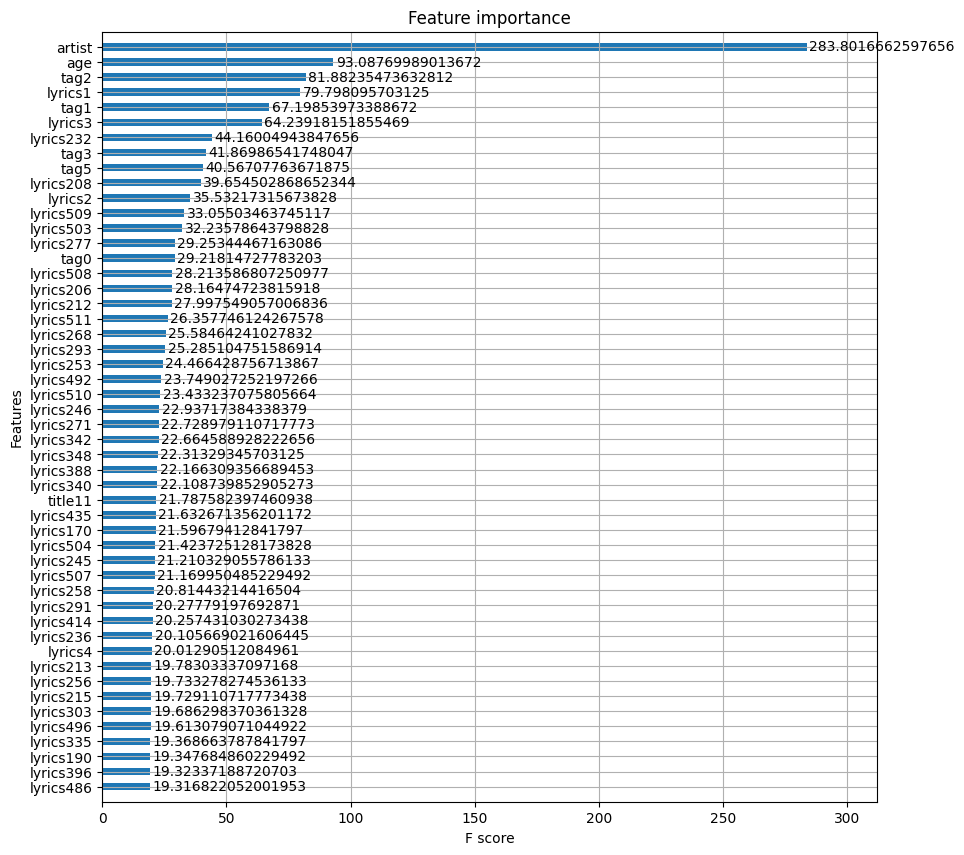

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.5, ax=ax,importance_type='gain')
plt.show()

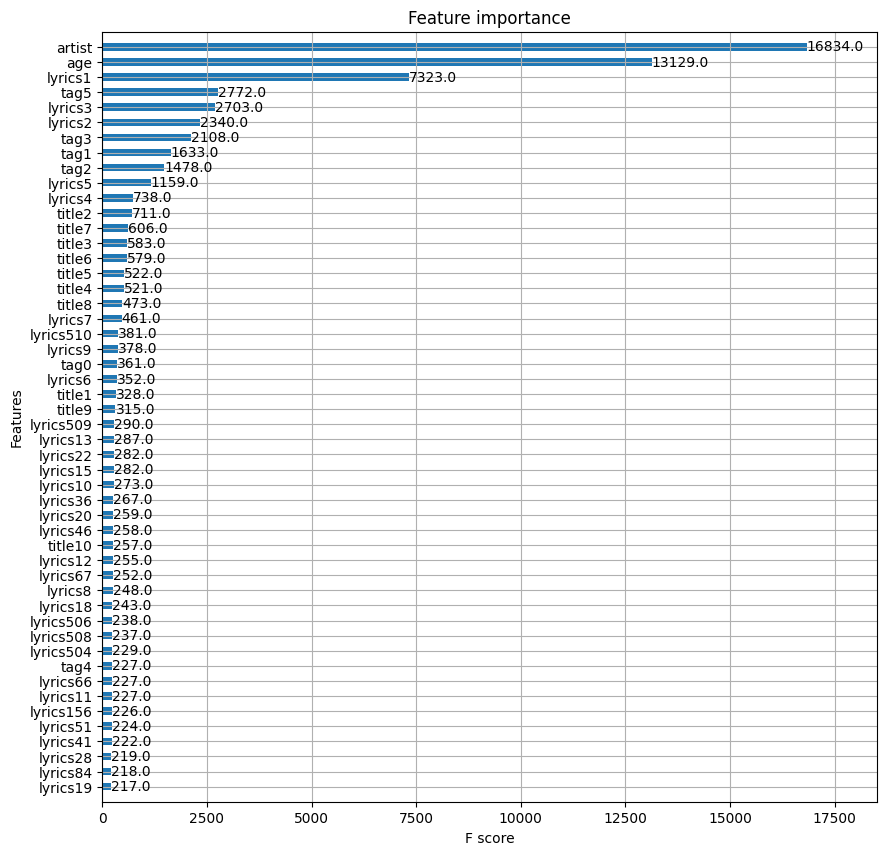

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgb_model, max_num_features=50, height=0.5, ax=ax,importance_type='weight')
plt.show()

Setup training for the Neural Network. We will try 3 different sets of hyper-parameters. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
data

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
# Get features in tensor form for neural network (ensure we only use training data here) => Also push to cuda

lyrics = torch.tensor(df_lyrics.loc[train_idx].values).type('torch.FloatTensor').to(device)
titles = torch.tensor(df_titles.loc[train_idx].values).type('torch.FloatTensor').to(device)
artists = torch.tensor(df_artists.loc[train_idx].values).unsqueeze(1).type('torch.FloatTensor').to(device)
age = torch.tensor(df_age.loc[train_idx].values).unsqueeze(1).type('torch.FloatTensor').to(device)
tags = torch.tensor(df_tags.loc[train_idx].values).type('torch.FloatTensor').to(device)
views = torch.tensor(df_views.loc[train_idx].values).type('torch.FloatTensor').to(device)

In [ ]:
print(lyrics.shape[1] + titles.shape[1] + 1 + 1 + tags.shape[1])

In [ ]:
# del lyrics, titles, artists, age, tags, views
# del model1

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Define the neural network architectures
class SongViewCountPredictor1(nn.Module):
    def __init__(self, input_size):
        super(SongViewCountPredictor1, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 20)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        self.soft = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [ ]:
# Define a custom dataset
class SongDataset(Dataset):
    def __init__(self, lyrics, titles, artists, age, tags, views):
        self.lyrics = lyrics
        self.titles = titles
        self.artists = artists
        self.age = age
        self.tags = tags
        self.views = views

    def __len__(self):
        return len(self.views)

    def __getitem__(self, index):
        lyrics = self.lyrics[index]
        titles = self.titles[index]
        artists = self.artists[index]
        age = self.age[index]
        tags = self.tags[index]
        views = self.views[index]
        return lyrics, titles, artists, age, tags, views

# Set random seed for reproducibility
torch.manual_seed(42)

# dataset = SongDataset(lyrics, titles, artists, age, tags, views)
# dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

# Define the model and optimizer (push models to GPU)
input_size = lyrics.shape[1] + titles.shape[1] + 1 + 1 + tags.shape[1] # (artists and age are size 1)
# model1 = SongViewCountPredictor1(input_size).to(device)
# model1 = torch.Sequential(
#     nn.Linear(input_size, 1024),
#     nn.ReLU(),
#     nn.Linear(1024, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Linear(256, 20),
#     optim.Adam(model1.parameters(), lr=0.0001),
# ).to(device)
# model2 = SongViewCountPredictor2(input_size).to(device)
#model3 = SongViewCountPredictor3(input_size).to(device)
# optimizer1 = optim.Adam(model1.parameters(), lr=0.0001)
# optimizer2 = optim.SGD(model2.parameters(), lr=0.0025)
#optimizer3 = optim.Adam(model3.parameters(), lr=0.0025)
# criterion = nn.CrossEntropyLoss() # using MSE as lossbb

In [ ]:
# #create torch sequential model with dropout
# model1 = torch.nn.Sequential(
#     nn.LSTM(input_size, 1024),
#     nn.ReLU(),
#     nn.LSTM(1024, 512),
#     nn.ReLU(),
#     nn.Dropout(0.2),
#     nn.LSTM(512, 256),
#     nn.ReLU(),
#     nn.LSTM(256, 20),
#     # nn.Softmax(dim=1) 
# ).to(device)

# optimizer1 = optim.Adam(model1.parameters())
# # optimizer2 = optim.SGD(model2.parameters(), lr=0.0025)
# #optimizer3 = optim.Adam(model3.parameters(), lr=0.0025)
# criterion = nn.CrossEntropyLoss() # using MSE as lossbb

In [ ]:
dataset = SongDataset(lyrics, titles, artists, age, tags, views)
dataloader = DataLoader(dataset, batch_size=(128), shuffle=True)

In [ ]:
from keras import layers as layers
from keras import models as models
from keras import optimizers as optimizers
from keras import losses as losses
from keras import metrics as metrics
import tensorflow as tf



In [ ]:
#printing tensorflow version
print(tf.__version__)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [ ]:
input_size

In [ ]:
model = models.Sequential()
model.add(layers.LSTM(1024, activation='relu', input_shape=(input_size,1)))
model.add(layers.LSTM(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(256, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.0001), loss = losses.categorical_crossentropy, metrics=['accuracy'])



In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    epoch_loss1 = 0.0
    epoch_loss2 = 0.0
    epoch_loss3 = 0.0
    for lyrics, titles, artists, age, tags, views in dataloader:
        # move batch data to GPU
        # lyrics = lyrics.to(device)
        # titles = titles.to(device)
        # artists = artists.to(device)
        # age = age.to(device)
        # tags = tags.to(device)
        # views = views.to(device)
        # Forward pass
        inputs = torch.cat((lyrics, titles, artists, age, tags), dim=1)
        outputs1 = model1(inputs)
        
        # Compute loss
        loss1 = criterion(outputs1, torch.argmax(views, dim=1))

        # Backward pass and optimization
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        
        epoch_loss1 += loss1.item()

    print(f"Epoch [{epoch+1}/{num_epochs}]:\n Loss1: {epoch_loss1/len(dataloader):.4f}") #\n Loss2: {epoch_loss2/len(dataloader):.4f} \n Loss3: {epoch_loss3/len(dataloader):.4f}\n")

In [ ]:
print(outputs1.shape)

In [ ]:
# Transform testing data into tensors (ensure we're only locating testing data)

lyrics = torch.tensor(df_lyrics.loc[test_idx].values).type('torch.FloatTensor').to(device)
titles = torch.tensor(df_titles.loc[test_idx].values).type('torch.FloatTensor').to(device)
artists = torch.tensor(df_artists.loc[test_idx].values).unsqueeze(1).type('torch.FloatTensor').to(device)
age = torch.tensor(df_age.loc[test_idx].values).unsqueeze(1).type('torch.FloatTensor').to(device)
tags = torch.tensor(df_tags.loc[test_idx].values).type('torch.FloatTensor').to(device)
views = torch.tensor(df_views.loc[test_idx].values).type('torch.FloatTensor').to(device)

In [ ]:
# Testing loop
# Set the model to evaluation mode - important for batch normalization and dropout layers
model1.eval()
#model2.eval()
#model3.eval()

dataset_test = SongDataset(lyrics, titles, artists, age, tags, views)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

size = len(dataloader_test.dataset)
num_batches = len(dataloader_test)

test_loss1, correct1 = 0, 0
test_loss2, correct2 = 0, 0
test_loss3, correct3 = 0, 0

loss_fn = nn.CrossEntropyLoss()

# Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
# also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
with torch.no_grad():
    for lyrics, titles, artists, age, tags, views in dataloader_test:
#         print(1)
        # move batch data to GPU
        lyrics = lyrics.to(device)
        titles = titles.to(device)
        artists = artists.to(device)
        age = age.to(device)
        tags = tags.to(device)
        views = views.to(device)
        
        # predict the views count
        X = torch.cat((lyrics, titles, artists, age, tags), dim=1)
        pred1 = model1(X)
#         pred2 = model2(X)
        #pred3 = model3(X)
        
        y = views
        test_loss1 += loss_fn(pred1, torch.argmax(y, dim = 1)).item()
#         print(torch.argmax(pred1, dim=1), "|||" , torch.argmax(y, dim=1))
        correct1 += (torch.argmax(nn.functional.softmax(pred1), dim=1) == torch.argmax(y, dim =1)).type(torch.float).sum().item()
        
#         test_loss2 += loss_fn(pred2, y).item()
#         correct2 += (torch.argmax(pred2, dim=1) == torch.argmax(y, dim =1)).type(torch.float).sum().item()        #
        #test_loss3 += loss_fn(pred3, y).item()
        #correct3 += (pred3.argmax(1) == y).type(torch.float).sum().item()

test_loss1 /= num_batches
correct1 /= size

# test_loss2 /= num_batches
# correct2 /= size
#
#test_loss3 /= num_batches
#correct3 /= size

print(f"Test Error 1: \n Accuracy: {(100*correct1):>0.1f}%, Avg loss: {test_loss1:>8f} \n Test Error 2: \n Accuracy: {(100*correct2):>0.1f}%, Avg loss: {test_loss2:>8f} \n Test Error 3: \n Accuracy: {(100*correct3):>0.1f}%, Avg loss: {test_loss3:>8f} \n")

In [ ]:
d1 = torch.cat((lyrics, titles, artists, age, tags), dim=1)[100]

In [ ]:
model1(d1)

In [ ]:
nn.functional.softmax(model1(d1)) 

In [ ]:
print(torch.argmax(views[120]), views[120])

In [ ]:
print(views[120].argmax())

In [ ]:
np.argmax(views[120].cpu().numpy())

In [ ]:
torch.argmax(model1(d1))

In [ ]:
# This cell for testing trained model manually

Now we train and test our KNN. We will use a RandomizedSearch to find the right hyperparams for this type of algorithm. 

In [ ]:
# Create a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

data_train = data.loc[train_idx]
X = data_train.drop(columns=['encoded_views'])
y = data_train['encoded_views']

parameters = {"n_neighbors": list(range(1, 30))}
    
model = KNeighborsClassifier()
random_search = RandomizedSearchCV(model, parameters, scoring="neg_mean_squared_error", cv=kfold, n_jobs=-1, verbose=100)
print(f"Fitting KNeighborsClassifer...")
random_search.fit(X, y)
print('\nKNN Regression Best Params: ', random_search.best_params_)

In [ ]:
# Testing KNN
model = KNeighborsClassifier(n_neighbors=random_search.best_params_['n_neighbors'])
model.fit(X,y)

data_test = data.loc[test_idx]
X_test = data_test.drop(columns=['encoded_views'])
y_test = data_test['encoded_views']

y_test_hat = model.predict(X_test) 

test_accuracy = accuracy_score(y_test, y_test_hat) * 100

print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy))